In [8]:
import pandas as pd, numpy as np, dataprep as dp
import torch

In [9]:
df = pd.read_csv("/Users/florian/Documents/github/study/IoT/IoT/aggregated_hourly.csv")
a0 = ["hka-aqm-a017", "hka-aqm-a014"]
a1 = ["hka-aqm-a101", "hka-aqm-a102", "hka-aqm-a103", "hka-aqm-a106", "hka-aqm-a107", "hka-aqm-a108", "hka-aqm-a111", "hka-aqm-a112"]

In [10]:
df_cutoff = df.copy
df_cutoff = dp.cutoff_data(df, "2023-01-13", "2023-03-28")
df_mean = dp.build_lvl_df(df_cutoff, a1, ["tmp", "hum", "CO2", "VOC"], reset_ind= True)
df_mean.head()

,tmp,hum,CO2,VOC
0,23.0950,34.000,573.0,754.0
1,23.1125,33.840,545.0,750.0
2,23.0950,33.865,532.0,741.0
3,23.1650,33.825,516.0,754.0
4,23.2725,33.780,507.0,767.0


In [11]:
df_mean[df_mean.isna() == True].count()

tmp    0
hum    0
CO2    0
VOC    0
dtype: int64

In [12]:
X = df_mean.to_numpy()
y = df_mean["tmp"].shift(-1).to_numpy()
X.shape, y.shape

((1775, 4), (1775,))

In [75]:
X_train, X_test, y_train, y_test = dp.train_test_split(X, y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1748, 4]),
 torch.Size([1748]),
 torch.Size([27, 4]),
 torch.Size([27]))

In [76]:
X_train_new, X_test_new = dp.format_tensor(X_train), dp.format_tensor(X_test)
X_train = X_train_new
X_test = X_test_new
y_train = y_train[1:]#.unsqueeze(1)
y_test = y_test[1:]#.unsqueeze(1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1747, 48, 4]),
 torch.Size([26, 48, 4]),
 torch.Size([1747]),
 torch.Size([26]))

In [77]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [78]:
from foo import LSTM

LSTM_model = LSTM(input_size=X_train.shape[2], hidden_size=100, num_layers=1, output_size=1)

In [81]:
num_epochs = 100
learning_rate = 0.00001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)

LSTM_model.train()
for epoch in range(num_epochs):
    for i, (features, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)
        output = LSTM_model(features)
        target = target.unsqueeze(1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/100], Step [10/28], Loss: 1.8584
Epoch [1/100], Step [20/28], Loss: 1.5908
Epoch [2/100], Step [10/28], Loss: 2.2242
Epoch [2/100], Step [20/28], Loss: 1.4372
Epoch [3/100], Step [10/28], Loss: 2.1518
Epoch [3/100], Step [20/28], Loss: 1.5083
Epoch [4/100], Step [10/28], Loss: 1.8657
Epoch [4/100], Step [20/28], Loss: 1.9961
Epoch [5/100], Step [10/28], Loss: 1.4882
Epoch [5/100], Step [20/28], Loss: 1.8113
Epoch [6/100], Step [10/28], Loss: 1.8692
Epoch [6/100], Step [20/28], Loss: 1.6743
Epoch [7/100], Step [10/28], Loss: 1.3516
Epoch [7/100], Step [20/28], Loss: 1.6583
Epoch [8/100], Step [10/28], Loss: 1.8347
Epoch [8/100], Step [20/28], Loss: 2.0471
Epoch [9/100], Step [10/28], Loss: 1.4724
Epoch [9/100], Step [20/28], Loss: 1.7120
Epoch [10/100], Step [10/28], Loss: 1.6583
Epoch [10/100], Step [20/28], Loss: 1.7860
Epoch [11/100], Step [10/28], Loss: 2.0840
Epoch [11/100], Step [20/28], Loss: 1.5939
Epoch [12/100], Step [10/28], Loss: 1.7049
Epoch [12/100], Step [20/28],

In [87]:
LSTM_model.eval()  # Set the model to evaluation mode

test_features, test_targets = next(iter(test_loader))  # Get a batch of test data
test_targets = test_targets.unsqueeze(1)  # Expand target to match the output shape
test_targets[-1] = 21.0213

with torch.no_grad():  # Disable gradient computation
    predictions = LSTM_model(test_features)  # Make predictions

# Calculate the mean squared error of the predictions
test_loss = criterion(predictions, test_targets)
print('Test Loss: {:.4f}'.format(test_loss.item()))

Test Loss: 1.1775


In [88]:
test_targets

tensor([[20.9122],
        [20.8471],
        [20.8037],
        [20.9935],
        [20.9821],
        [20.9251],
        [20.8888],
        [20.8687],
        [20.9183],
        [20.6574],
        [21.4696],
        [22.5116],
        [22.6053],
        [22.5800],
        [22.5087],
        [22.4242],
        [22.4840],
        [22.5582],
        [22.5919],
        [22.5121],
        [22.1749],
        [21.9574],
        [21.7229],
        [21.4908],
        [21.2156],
        [21.0213]])

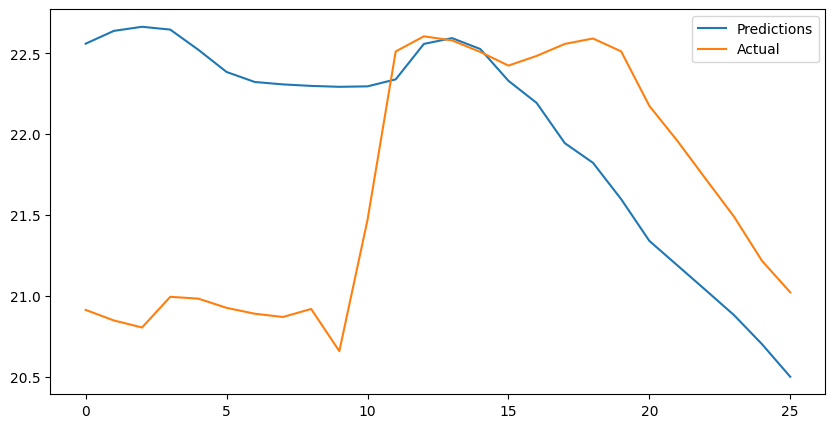

In [97]:
import matplotlib.pyplot as plt
# Convert numpy array to PyTorch tensor
predictions = torch.from_numpy(predictions)
test_targets = torch.from_numpy(test_targets)

# Continue with the rest of the code

plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions')
plt.plot(test_targets, label='Actual')
plt.legend()
plt.show()